# swin3d_b (30 animal classes)

In [ ]:
#%%python3 -m pip install --upgrade pip

In [1]:
%pip install mediapipe=='0.10.9'
%pip install opencv-python=='4.8.0.76'

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from utils import VideoDataset, validate_model, validate_model_batched, train_model, display_frames

2024-02-18 08:03:34.074543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 08:03:37.703165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import json

In [4]:
def save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic):
    with open(f'{save_path}/{model_name}_loss_acc_dynamic.json', 'w') as f:
        json.dump(
            {
                'train_loss_dynamic': train_loss_dynamic,
                'val_accuracy_dynamic': val_accuracy_dynamic
            },
            f)

In [5]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1
IMG_SIZE = 112

limit_list = [] #["динозавр", "пингвин", "кролик"]

min_frame_count = 25

save = True

annotations_file = "/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DF_SHORT.tsv" #  "/content/drive/MyDrive/slovo/SLOVO_DF_SHORT.tsv" #
dataloader_dir = "/home/jupyter/mnt/s3/rsl-videos/slovo/Dataloaders/animals/" #  "/content/drive/MyDrive/slovo/dataloaders/" #

train_dataloader_name = 'color_frames_train_dataloader.pth'
val_dataloader_name = 'color_frames_val_dataloader.pth'

save_path = "/home/jupyter/mnt/s3/rsl-videos/slovo/models/animals/swinb" #'/content/drive/MyDrive/slovo/models/ResNet18' # '/content/model' #

In [6]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<17,'train', np.where(video_labels['group_rank']<19,'val', 'test'))
if len(limit_list)>0:
  video_labels = video_labels[video_labels.text.isin(limit_list)]
video_labels.tail(5)

,Unnamed: 0,attachment_id,text,begin,end,group_rank,dataset
595,55,25b5fb58-46dd-4fd6-9928-734460795b22,мышь,22,83,20,test
596,56,336e0e7a-ff68-427c-9a77-52626b81edd1,паук,42,74,19,test
597,57,d0ec4c00-6ff5-4089-ac9d-5a33a76fb037,паук,3,70,20,test
598,58,59ae408b-f87a-422a-bc57-2ff5af28ee57,бабочка,2,74,19,test
599,59,e421d77c-1dcd-4124-b2a4-b2415569a4dd,бабочка,63,131,20,test


In [7]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 30. Example classes: ('пингвин', 'жираф', 'лягушка', 'бегемот', 'козел')


In [8]:
train_dataloader = torch.load(dataloader_dir + train_dataloader_name)
print(f"Train dataloader contains: {len(train_dataloader)} videos")
val_dataloader = torch.load(dataloader_dir + val_dataloader_name)
print(f"Val dataloader contains: {len(val_dataloader)} videos")

Train dataloader contains: 480 videos
Val dataloader contains: 60 videos


In [9]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  for dl in [train_dataloader, val_dataloader]:
    dl.num_workers = 0
    dl.pin_memory = True
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(f"Device: {device}")

Device: cuda


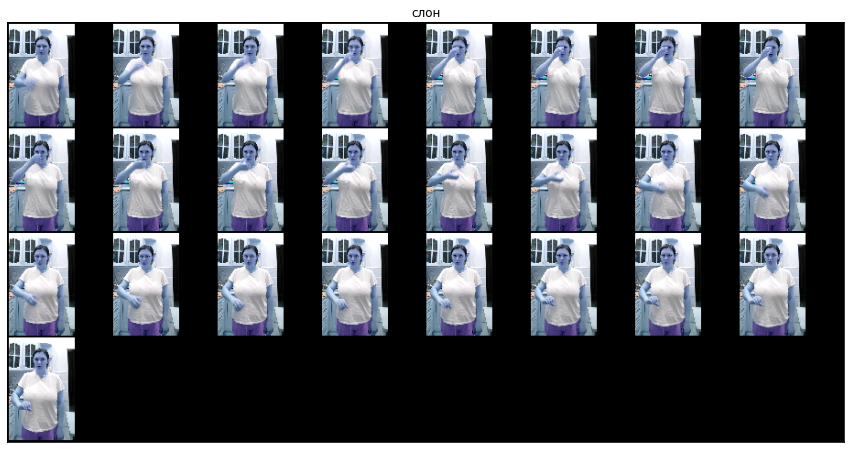

In [10]:
display_frames(n_frames=1, dataloader=train_dataloader, classes=classes)

In [11]:
frames, labels = next(iter(val_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 112, 112])
# frames = frames.permute(0,2,1,3,4) # (B, T, C, H, W) for swin
# print(f"Frames shape: {frames.shape}") #
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 25, 112, 112])
Labels shape: torch.Size([1])
Labels: tensor([27])


# Swin B, $lr = 10^{-5}$

In [12]:
# https://pytorch.org/vision/main/models/generated/torchvision.models.video.swin3d_b.html#torchvision.models.video.swin3d_b
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

Downloading: "https://download.pytorch.org/models/swin3d_b_22k-7c6ae6fa.pth" to /tmp/xdg_cache/torch/hub/checkpoints/swin3d_b_22k-7c6ae6fa.pth
100%|██████████| 364M/364M [00:10<00:00, 37.4MB/s] 


Linear(in_features=1024, out_features=30, bias=True)

In [13]:
frames, labels = next(iter(val_dataloader))
frames = frames.to(device)
swinb.to(device)
print(f"Output shape: {swinb(frames/255).shape}") # batch size, number of classes

Output shape: torch.Size([1, 30])


In [14]:
lr = 10**(-5)
model_name = "swinb_animals_lr10-5"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)

In [15]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)
    

Train Epoch 1/30: train_loss=3.3799; val acc=0.183
Train Epoch 2/30: train_loss=1.9539; val acc=0.617
Train Epoch 3/30: train_loss=0.5086; val acc=0.700
Train Epoch 4/30: train_loss=0.0991; val acc=0.817
Train Epoch 5/30: train_loss=0.0245; val acc=0.833
Train Epoch 6/30: train_loss=0.0113; val acc=0.817
Train Epoch 7/30: train_loss=0.0071; val acc=0.817
Train Epoch 8/30: train_loss=0.0048; val acc=0.833
Train Epoch 9/30: train_loss=0.0034; val acc=0.800
Train Epoch 10/30: train_loss=0.0024; val acc=0.800
Train Epoch 11/30: train_loss=0.0018; val acc=0.800
Train Epoch 12/30: train_loss=0.0013; val acc=0.800
Train Epoch 13/30: train_loss=0.001; val acc=0.783
Train Epoch 14/30: train_loss=0.0007; val acc=0.800
Train Epoch 15/30: train_loss=0.0005; val acc=0.783
Train Epoch 16/30: train_loss=0.0004; val acc=0.783
Train Epoch 17/30: train_loss=0.0003; val acc=0.783
Train Epoch 18/30: train_loss=0.0002; val acc=0.783
Train Epoch 19/30: train_loss=0.0002; val acc=0.783
Train Epoch 20/30: tra

# Swin CosineAnnealingLR 3 * (10**(-4))

#https://minibatchai.com/2021/07/09/Cosine-LR-Decay.html
    #

In [16]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

Linear(in_features=1024, out_features=30, bias=True)

In [17]:
lr = 3 * (10**(-4))
num_epoches = 30
model_name = "swinb_animals_lrcd-4"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [18]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.5425; val acc=0.033, lr=0.0002991783 : 0.0002991783
Train Epoch 2/30: train_loss=3.4921; val acc=0.033, lr=0.0002967221 : 0.0002967221
Train Epoch 3/30: train_loss=3.4604; val acc=0.033, lr=0.0002926585 : 0.0002926585
Train Epoch 4/30: train_loss=3.4548; val acc=0.033, lr=0.0002870318 : 0.0002870318
Train Epoch 5/30: train_loss=3.4366; val acc=0.033, lr=0.0002799038 : 0.0002799038
Train Epoch 6/30: train_loss=3.4492; val acc=0.033, lr=0.0002713525 : 0.0002713525
Train Epoch 7/30: train_loss=3.4456; val acc=0.033, lr=0.0002614717 : 0.0002614717
Train Epoch 8/30: train_loss=3.4372; val acc=0.033, lr=0.0002503696 : 0.0002503696
Train Epoch 9/30: train_loss=3.4331; val acc=0.033, lr=0.0002381678 : 0.0002381678
Train Epoch 10/30: train_loss=3.4456; val acc=0.033, lr=0.0002250000 : 0.0002250000
Train Epoch 11/30: train_loss=3.4354; val acc=0.033, lr=0.0002110105 : 0.0002110105
Train Epoch 12/30: train_loss=3.4267; val acc=0.033, lr=0.0001963525 : 0.0001963525
T

# Swin CosineAnnealingLR 3 * (10**(-5))

In [19]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

Linear(in_features=1024, out_features=30, bias=True)

In [20]:
lr = 3 * (10**(-5))
num_epoches = 30
model_name = "swinb_animals_lrcd-5"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [21]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.2439; val acc=0.217, lr=0.0000299178 : 0.0000299178
Train Epoch 2/30: train_loss=1.8031; val acc=0.583, lr=0.0000296722 : 0.0000296722
Train Epoch 3/30: train_loss=0.6262; val acc=0.683, lr=0.0000292658 : 0.0000292658
Train Epoch 4/30: train_loss=0.2683; val acc=0.650, lr=0.0000287032 : 0.0000287032
Train Epoch 5/30: train_loss=0.1904; val acc=0.783, lr=0.0000279904 : 0.0000279904
Train Epoch 6/30: train_loss=0.0432; val acc=0.767, lr=0.0000271353 : 0.0000271353
Train Epoch 7/30: train_loss=0.0039; val acc=0.833, lr=0.0000261472 : 0.0000261472
Train Epoch 8/30: train_loss=0.0014; val acc=0.833, lr=0.0000250370 : 0.0000250370
Train Epoch 9/30: train_loss=0.001; val acc=0.833, lr=0.0000238168 : 0.0000238168
Train Epoch 10/30: train_loss=0.0008; val acc=0.833, lr=0.0000225000 : 0.0000225000
Train Epoch 11/30: train_loss=0.0006; val acc=0.833, lr=0.0000211010 : 0.0000211010
Train Epoch 12/30: train_loss=0.0005; val acc=0.833, lr=0.0000196353 : 0.0000196353
Tr

# Swin CosineAnnealingLR 3 * (10**(-6))

In [ ]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

In [ ]:
lr = 3 * (10**(-6))
num_epoches = 30
model_name = "swinb_animals_lrcd-6"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

# Update batch size to 4

In [ ]:
bs = 4
val_dataloader = DataLoader(val_dataloader.dataset, batch_size=bs, shuffle=False, sampler=None)
train_dataloader = DataLoader(train_dataloader.dataset, batch_size=bs, shuffle=True, sampler=None)
print(val_dataloader.batch_size, train_dataloader.batch_size)

# Swin CosineAnnealingLR 3 * (10**(-5)) bs = 4

In [ ]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

In [ ]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"swinb_animals_lrcd{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

# Swin CosineAnnealingLR 3 * (10**(-6)) bs = 4

In [ ]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

In [ ]:
lr_power = -6
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"swinb_animals_lrcd{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

# Update batch size to 8

In [ ]:
bs = 8
val_dataloader = DataLoader(val_dataloader.dataset, batch_size=bs, shuffle=False, sampler=None)
train_dataloader = DataLoader(train_dataloader.dataset, batch_size=bs, shuffle=True, sampler=None)
print(val_dataloader.batch_size, train_dataloader.batch_size)

# Swin CosineAnnealingLR 3 * (10**(-5)) bs = 8

In [ ]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

In [ ]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"swinb_animals_lrcd{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

# Swin CosineAnnealingLR 3 * (10**(-6)) bs = 8

In [ ]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

In [ ]:
lr_power = -6
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"swinb_animals_lrcd{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

# Update batch size to 16

In [ ]:
bs = 16
val_dataloader = DataLoader(val_dataloader.dataset, batch_size=bs, shuffle=False, sampler=None)
train_dataloader = DataLoader(train_dataloader.dataset, batch_size=bs, shuffle=True, sampler=None)
print(val_dataloader.batch_size, train_dataloader.batch_size)

# Swin CosineAnnealingLR 3 * (10**(-5)) bs = 16

In [ ]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

In [ ]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"swinb_animals_lrcd{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

# Swin CosineAnnealingLR 3 * (10**(-6)) bs = 16

In [ ]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

In [ ]:
lr_power = -6
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"swinb_animals_lrcd{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)